## Retrieve Dataset

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import utils
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Train Dataset

In [3]:
transform_rand = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
transform_user = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    utils.AddGaussianNoise(p=0.25, mean=0, std=0.02),
    torchvision.transforms.RandomErasing(p=0.33, scale=(0.02, 0.05), ratio=(1,1))
])

In [4]:
batch_size = 32
# Load ffhq 256x256 training dataset
train_ffhq = torchvision.datasets.ImageFolder(
    './dataset/train/ffhq', transform=transform_rand)
train_ffhq_loader = torch.utils.data.DataLoader(
    train_ffhq, batch_size=batch_size, shuffle=True, pin_memory=True,
    num_workers=4)

# Load user training dataset.
train_users = torchvision.datasets.ImageFolder(
    './dataset/train/users', transform=transform_user)
# Only a single image is loaded at a time due to much less images compared to ffhq
train_users_loader = torch.utils.data.DataLoader(
    train_users, batch_size=1, shuffle=True, pin_memory=True)

In [5]:
train_users_iter = iter(train_users_loader)
def get_user_img():
    global train_users_iter
    try:
        return next(train_users_iter) 
    except StopIteration:
        # StopIteration is thrown if dataset ends
        # reinitialize data loader 
        train_users_iter = iter(train_users_loader)
        return next(train_users_iter)

### Test Dataset

In [6]:
# New transforms without data augmentation
transform_user_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


# Load ffhq 256x256 testing dataset
test_ffhq = torchvision.datasets.ImageFolder(
    './dataset/test/ffhq', transform=transform_rand)
test_ffhq_loader = torch.utils.data.DataLoader(
    test_ffhq, batch_size=2, shuffle=True, pin_memory=True,
    num_workers=4)

# Load user testing dataset.
test_users = torchvision.datasets.ImageFolder(
    './dataset/test/users', transform=transform_user_test)
# Only a single image is loaded at a time due to much less images compared to ffhq
test_users_loader = torch.utils.data.DataLoader(
    test_users, batch_size=1, shuffle=True, pin_memory=True)

In [7]:
test_users_iter = iter(test_users_loader)
def get_user_test_img():
    global test_users_iter
    try:
        return next(test_users_iter) 
    except StopIteration:
        # StopIteration is thrown if dataset ends
        # reinitialize data loader 
        test_users_iter = iter(test_users_loader)
        return next(test_users_iter)

def get_model_accuracy(model_path):
    model_test = torch.load(model_path).eval()
    prediction = []
    target = []
    for data in test_ffhq_loader:
        images, labels = data
        user_img, label = get_user_test_img()

        images[1] = user_img[0]
        labels[1] = label[0] + 1

        with torch.no_grad():
            output = model_test(images.to(device))

        softmax = torch.nn.Softmax(dim=1)(output)
        predictions = np.argmax(softmax.cpu(), axis=1)
        prediction.append(predictions)
        target.append(labels)

    accuracy = []
    for i in range(len(prediction)):
        accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
    return np.average(accuracy)

## Define Model

In [8]:
model = torchvision.models.mobilenet_v3_large()
model.classifier

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)

In [9]:
# Change number of categories to match number of classes in dataset
fc = nn.Sequential(
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(train_users.classes) + 1, bias=True)
)
model.classifier = fc
model = model.to(device)

## Train Model

In [10]:
# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.00166)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 10

In [11]:
loss_epoch = []
val_loss_epoch = []
for epoch in range(epochs):  # Loop over the dataset multiple times
    training_loss = []
    for data in tqdm(train_ffhq_loader):
        images, labels = data
        user_img, label = get_user_img()

        replace_idx = np.random.randint(images.shape[0])

        # Randomly replace one image in batch with a user image
        images[replace_idx] = user_img[0]
        labels[replace_idx] = label[0] + 1

        # Prevent cumulative gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        training_loss.append(loss.item())
        
        # Backward pass
        loss.backward()
        # Optimize
        optimizer.step()

    training_loss = np.average(training_loss)
    loss_epoch.append(training_loss)
    print(f"epoch: {epoch}, training loss: {training_loss}")
    model_out_path = f'model/mn-large-{epoch:02}.pt'
    torch.save(model, model_out_path)
    
    # Test last epoch
    val_loss_epoch.append(get_model_accuracy(model_out_path))
    print(f"           Model Accuracy: {val_loss_epoch[-1]}")

print('Finished Training')

100%|██████████████████████████████████████████████████████████████████████████████| 2157/2157 [04:45<00:00,  7.55it/s]


epoch: 0, training loss: 0.02414964166610001
           Model Accuracy: 0.99


100%|██████████████████████████████████████████████████████████████████████████████| 2157/2157 [04:44<00:00,  7.57it/s]


epoch: 1, training loss: 0.0064740449946113585
           Model Accuracy: 0.996


100%|██████████████████████████████████████████████████████████████████████████████| 2157/2157 [04:40<00:00,  7.70it/s]


epoch: 2, training loss: 0.015388010976633075
           Model Accuracy: 0.996


100%|██████████████████████████████████████████████████████████████████████████████| 2157/2157 [04:38<00:00,  7.76it/s]


epoch: 3, training loss: 0.007202918490756412
           Model Accuracy: 1.0


100%|██████████████████████████████████████████████████████████████████████████████| 2157/2157 [04:43<00:00,  7.61it/s]


epoch: 4, training loss: 0.004104199452944052
           Model Accuracy: 0.857


100%|██████████████████████████████████████████████████████████████████████████████| 2157/2157 [04:47<00:00,  7.51it/s]


epoch: 5, training loss: 0.008404054088788537
           Model Accuracy: 0.929


100%|██████████████████████████████████████████████████████████████████████████████| 2157/2157 [04:57<00:00,  7.24it/s]


epoch: 6, training loss: 0.004340892371630392
           Model Accuracy: 0.928


100%|██████████████████████████████████████████████████████████████████████████████| 2157/2157 [04:51<00:00,  7.40it/s]


epoch: 7, training loss: 0.0033934354094950154
           Model Accuracy: 0.785


100%|██████████████████████████████████████████████████████████████████████████████| 2157/2157 [04:51<00:00,  7.41it/s]


epoch: 8, training loss: 0.0035243963874152817
           Model Accuracy: 0.929


100%|██████████████████████████████████████████████████████████████████████████████| 2157/2157 [04:54<00:00,  7.32it/s]


epoch: 9, training loss: 0.005003518718625753
           Model Accuracy: 0.573
Finished Training


In [12]:
torch.cuda.empty_cache()

Text(0.5, 1.0, 'Training Loss vs Epoch')

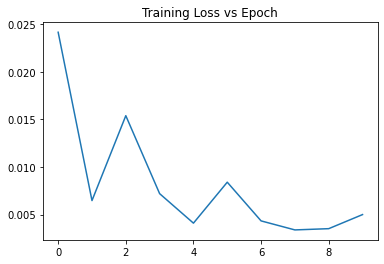

In [13]:
plt.plot(loss_epoch)
plt.title("Training Loss vs Epoch")

Text(0.5, 1.0, 'Accuracy vs Epoch')

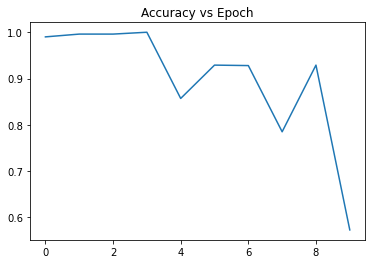

In [14]:
plt.plot(val_loss_epoch)
plt.title("Accuracy vs Epoch")

In [15]:
params = 0
for param in list(model.parameters()):
    params += np.product(param.shape)
params

4204594

In [16]:
selected_model = torch.load('model/mn-large-01.pt')

In [17]:
selected_model = torch.jit.script(selected_model.to('cpu'))

In [18]:
selected_model.save('model/mn-large-01_ts.pt')